In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
"""
returns percentage of authors and editors that are male as a dictionary
"""
def gender_plot_each_year(author_data, editor_names, editor_genders, year):
    authors = pd.read_csv(author_data).drop(labels=['Unnamed: 0', 'PaperTitle', 'OnlineDate', 'JournalId', 
                                                    'OriginalVenue', 'CreatedDate'], axis=1)
    editors = pd.read_csv(editor_names, names=["Editor", "Role", "x", "y", "z"])
    editor_genders = pd.read_csv(editor_genders, names=["Editor", "Gender", "Probability"])
    
    authors = authors[authors['Year'] == year]
    author_gender_percentage = -1
    if len(authors) > 0:
        author_genders = authors[authors['GenderProbability'] >= 0.90]
        author_gender_percentage = (author_genders['Gender'].value_counts() / len(author_genders))
        if 'male' in author_gender_percentage:
            author_gender_percentage = author_gender_percentage['male']
        else:
            author_gender_percentage = 0

    editors = editors.join(editor_genders.set_index('Editor'), on=['Editor'], how='left')
    editor_gender_percentage = -1
    if len(editors) > 0:
        editors = editors[editors['Probability'] >= 0.90]
        editor_gender_percentage = (editors['Gender'].value_counts() / len(editors))
        if 'male' in editor_gender_percentage:
            editor_gender_percentage = editor_gender_percentage['male']
        else:
            editor_gender_percentage = 0
        
    return {"author": float( '%.3f'%(author_gender_percentage)), 
            "editor": float( '%.3f'%(editor_gender_percentage))}

In [3]:
"""
returns percentage of authors and editors that are male (in year buckets) as a dictionary
"""
def gender_plot_buckets(author_data, editor_genders, journal, start, end, magic):
    authors = pd.read_csv(author_data).drop(labels=['Unnamed: 0', 'PaperTitle', 'OnlineDate', 'JournalId', 
                                                    'OriginalVenue', 'CreatedDate'], axis=1)
    editor_genders = pd.read_csv(editor_genders, names=["Editor", "Gender", "Probability"])
    
    bucket_authors = pd.DataFrame()
    for i in range(start, end+1):
        bucket_authors = pd.concat([bucket_authors, authors[authors['Year'] == i]])
    author_gender_percentage = -1
    if len(bucket_authors) > 0:
        author_genders = bucket_authors[bucket_authors['GenderProbability'] >= 0.90]
        author_gender_percentage = (author_genders['Gender'].value_counts() / len(author_genders))
        if 'male' in author_gender_percentage:
            author_gender_percentage = author_gender_percentage['male']
        else:
            author_gender_percentage = 0
            
    bucket_editors = pd.DataFrame()
    for j in range(start, end+1):
        k = j - magic
        editors = pd.read_csv(f"../editor_data/extracted_names/{journal}/{journal}.{k}.extracted.txt", 
                              names=["Editor", "Role", "x", "y", "z"])
        editors = editors.join(editor_genders.set_index('Editor'), on=['Editor'], how='left')
        bucket_editors = pd.concat([bucket_editors, editors])
    editor_gender_percentage = -1
    if len(bucket_editors) > 0:
        bucket_editors = bucket_editors[bucket_editors['Probability'] >= 0.90]
        editor_gender_percentage = (bucket_editors['Gender'].value_counts() / len(bucket_editors))
        if 'male' in editor_gender_percentage:
            editor_gender_percentage = editor_gender_percentage['male']
        else:
            editor_gender_percentage = 0
    
    return {"author": float( '%.3f'%(author_gender_percentage)), 
            "editor": float( '%.3f'%(editor_gender_percentage))}

In [4]:
"""
gets aggregate results across all available years for a journal
"""
def call_gender_plot_year(journal, start, end, magic):
    aggregate = {}
    for i in range(start, end+1):
        res = gender_plot_each_year(f"../author_data/gender/{journal}_authors_genderize.csv", 
                                    f"../editor_data/extracted_names/{journal}/{journal}.{i}.extracted.txt", 
                                    f"../editor_data/analysis/genderize/{journal}.genderize.aggregate.csv", 
                                    magic+i)
        aggregate[magic+i] = res
    return aggregate

In [5]:
def call_gender_plot_bucket(journal, start, end, magic):
    aggregate = {}
    cutoff = start + 4
    
    while cutoff <= end:
        res = gender_plot_buckets(f"../author_data/gender/{journal}_authors_genderize.csv",
                                  f"../editor_data/analysis/genderize/{journal}.genderize.aggregate.csv",
                                  journal, start, cutoff, magic)
        aggregate[f"{start}-{cutoff}"] = res
        start += 5
        cutoff += 5

    if start <= end:
        res = gender_plot_buckets(f"../author_data/gender/{journal}_authors_genderize.csv",
                                  f"../editor_data/analysis/genderize/{journal}.genderize.aggregate.csv",
                                  journal, start, end, magic)
        aggregate[f"{start}-{end}"] = res
    return aggregate

In [10]:
aer_gender = call_gender_plot_year("aer", 84, 113, 1910)
eco_gender = call_gender_plot_year("eco", 75, 91, 1932)
jpe_gender = call_gender_plot_year("jpe", 125, 131, 1892)
qje_gender = call_gender_plot_year("qje", 109, 138, 1885)
res_gender = call_gender_plot_year("res", 61, 90, 1933)

In [7]:
aer_buckets = call_gender_plot_bucket("aer", 1994, 2023, 1910)
eco_buckets = call_gender_plot_bucket("eco", 2007, 2023, 1932)
jpe_buckets = call_gender_plot_bucket("jpe", 2017, 2023, 1892)
qje_buckets = call_gender_plot_bucket("qje", 1994, 2023, 1885)
res_buckets = call_gender_plot_bucket("res", 1994, 2023, 1933)

In [11]:
def plot_gender(journal, data):
    years = sorted(data.keys())
    authors = []
    editors = []
    for year in years:
        if data[year]['author'] == -1:
            authors.append(0)
        else:
            authors.append(1-data[year]['author'])
        if data[year]['editor'] == -1:
            editors.append(0)
        else:
            editors.append(1-data[year]['editor'])
    
    axes = plt.axes()
    axes.set_ylim([0, 1])
    plt.plot(years, authors, label='authors')
    plt.plot(years, editors, label='editors')
    plt.title(f'Percentage of Female Contributors at {journal.upper()}')
    plt.xticks(years, rotation=90)
    plt.legend()
    plt.show()

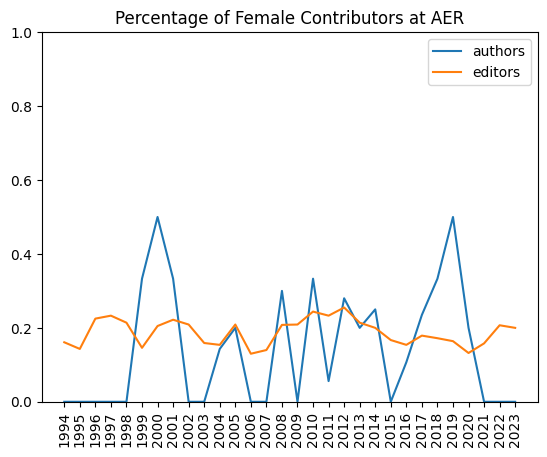

In [15]:
"""
yearly data
"""
plot_gender("aer", aer_gender)

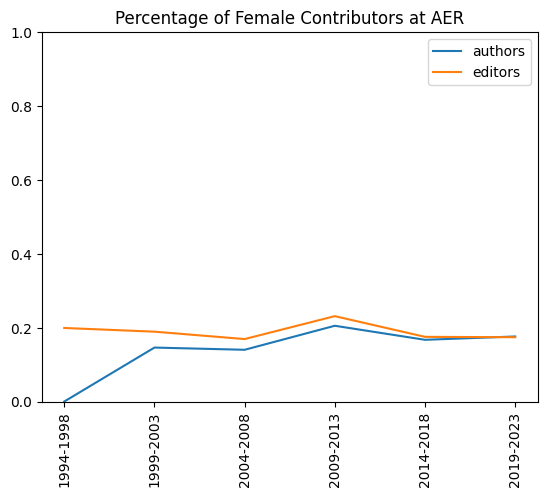

In [16]:
"""
bucketized
"""
plot_gender("aer", aer_buckets)

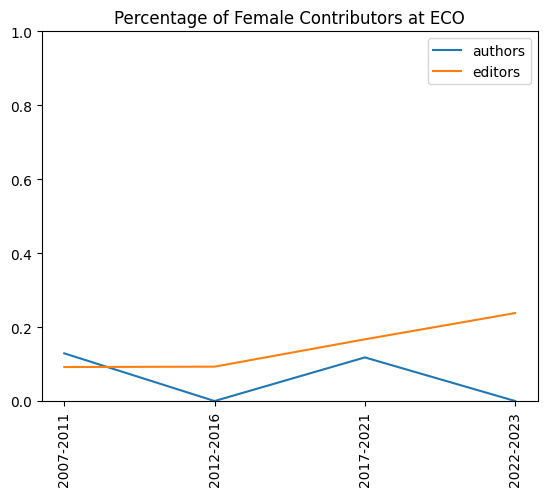

In [10]:
plot_gender("eco", eco_buckets)

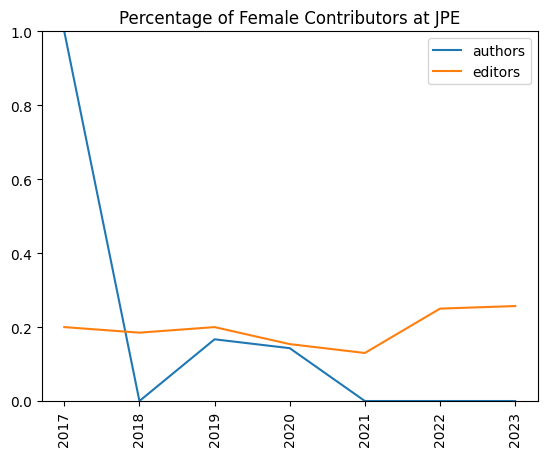

In [13]:
# modify so each journal has six buckets
plot_gender("jpe", jpe_gender)

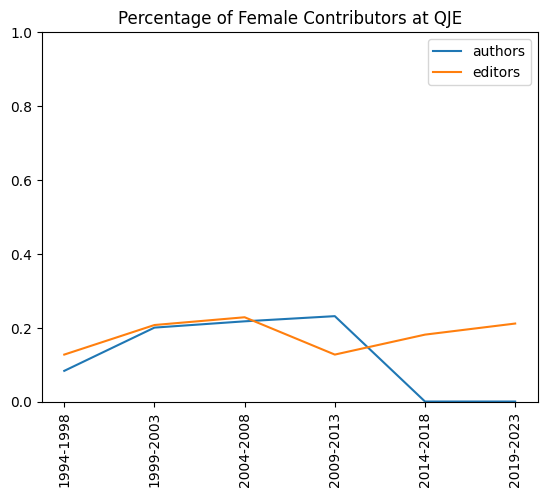

In [12]:
plot_gender("qje", qje_buckets)

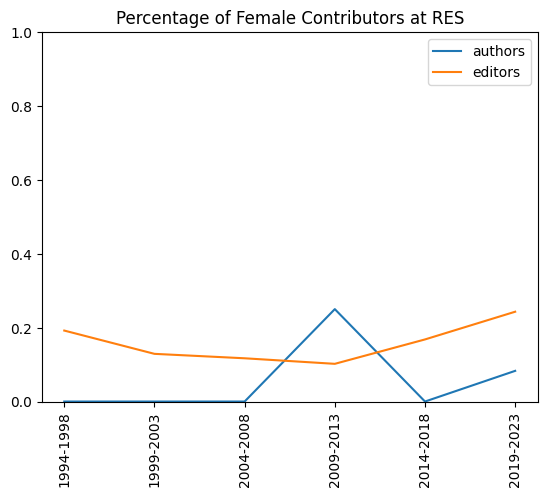

In [13]:
plot_gender("res", res_buckets)